In [1]:
import pandas as pd
import numpy as np
import random as rnd
import os
import datetime
import pickle
import time

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook

from itertools import product
import itertools

import gc

import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)

import warnings
warnings.filterwarnings('ignore')

In [2]:
from keras.models import Sequential
from keras.layers import Dense,BatchNormalization,Dropout
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from keras.utils import to_categorical
import tensorflow as tf
from keras import backend as K
import keras
from keras import regularizers
from collections import Counter
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [3]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [4]:
train_meta = pd.read_csv('./input/training_set_metadata.csv', engine='python')
test_meta = pd.read_csv('./input/test_set_metadata.csv', engine='python')

In [5]:
train_meta.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


In [6]:
test_meta.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv
0,13,34.453125,-5.229529,169.987075,-59.956185,1,0.3048,0.3193,0.0542,41.1123,0.019
1,14,33.398438,-4.331149,167.226341,-59.936551,1,NaN,0.6323,0.0179,42.8774,0.018
2,17,348.529419,-61.755440,321.293980,-51.763351,1,NaN,0.8297,0.0605,43.6000,0.016
3,23,34.804688,-5.829153,171.307861,-60.174401,1,NaN,0.6533,0.1479,42.9640,0.023
4,34,351.321442,-64.198746,317.458993,-50.429931,1,0.4557,0.4617,0.0122,42.0540,0.023


In [7]:
train_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7848 entries, 0 to 7847
Data columns (total 12 columns):
object_id             7848 non-null int64
ra                    7848 non-null float64
decl                  7848 non-null float64
gal_l                 7848 non-null float64
gal_b                 7848 non-null float64
ddf                   7848 non-null int64
hostgal_specz         7848 non-null float64
hostgal_photoz        7848 non-null float64
hostgal_photoz_err    7848 non-null float64
distmod               5523 non-null float64
mwebv                 7848 non-null float64
target                7848 non-null int64
dtypes: float64(9), int64(3)
memory usage: 735.8 KB


In [8]:
test_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3492890 entries, 0 to 3492889
Data columns (total 11 columns):
object_id             int64
ra                    float64
decl                  float64
gal_l                 float64
gal_b                 float64
ddf                   int64
hostgal_specz         float64
hostgal_photoz        float64
hostgal_photoz_err    float64
distmod               float64
mwebv                 float64
dtypes: float64(9), int64(2)
memory usage: 293.1 MB


In [9]:
test_meta.describe()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv
count,3.492890e+06,3.492890e+06,3.492890e+06,3.492890e+06,3.492890e+06,3.492890e+06,120393.000000,3.492890e+06,3.492890e+06,3.102380e+06,3.492890e+06
mean,6.528181e+07,1.705897e+02,-2.624964e+01,2.178545e+02,-1.843280e+01,9.426578e-03,0.305988,5.168159e-01,1.535211e-01,4.217862e+01,9.196644e-02
std,3.783131e+07,1.092068e+02,1.764381e+01,1.081992e+02,3.958926e+01,9.663188e-02,0.159928,4.491342e-01,2.752581e-01,1.587242e+00,1.551435e-01
min,1.300000e+01,0.000000e+00,-6.476086e+01,1.036900e-02,-8.967441e+01,0.000000e+00,0.007700,0.000000e+00,0.000000e+00,2.764620e+01,2.000000e-03
25%,3.252507e+07,7.277344e+01,-4.042390e+01,1.733004e+02,-5.280274e+01,0.000000e+00,0.192600,2.683000e-01,1.380000e-02,4.124470e+01,2.300000e-02
50%,6.530507e+07,1.611914e+02,-2.511770e+01,2.459314e+02,-2.448392e+01,0.000000e+00,0.295800,4.619000e-01,3.030000e-02,4.227200e+01,4.500000e-02
75%,9.805302e+07,2.758614e+02,-1.126298e+01,2.983127e+02,1.726843e+01,0.000000e+00,0.406000,6.557000e-01,1.432000e-01,4.308390e+01,9.100000e-02
max,1.307881e+08,3.598242e+02,4.181528e+00,3.599956e+02,6.606870e+01,1.000000e+00,1.201400,3.000000e+00,1.871400e+00,4.702610e+01,2.994000e+00


In [10]:
train = pd.read_csv('./input/training_set.csv')

In [11]:
train.head()

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [12]:
train['flux_ratio_sq'] = np.power(train['flux'] / train['flux_err'], 2.0)
train['flux_by_flux_ratio_sq'] = train['flux'] * train['flux_ratio_sq']

In [13]:
train.head()

,object_id,mjd,passband,flux,flux_err,detected,flux_ratio_sq,flux_by_flux_ratio_sq
0,615,59750.4229,2,-544.810303,3.622952,1,22613.379109,-1.232000e+07
1,615,59750.4306,1,-816.434326,5.553370,1,21613.708602,-1.764617e+07
2,615,59750.4383,3,-471.385529,3.801213,1,15378.291200,-7.249104e+06
3,615,59750.4450,4,-388.984985,11.395031,1,1165.291701,-4.532810e+05
4,615,59752.4070,2,-681.858887,4.041204,1,28468.688609,-1.941163e+07


In [14]:
aggs = {
    'mjd': ['min', 'max', 'size'],
    'passband': ['min', 'max', 'mean', 'median', 'std'],
    'flux': ['min', 'max', 'mean', 'median', 'std','skew'],
    'flux_err': ['min', 'max', 'mean', 'median', 'std','skew'],
    'detected': ['mean'],
    'flux_ratio_sq':['sum','skew'],
    'flux_by_flux_ratio_sq':['sum','skew'],
}

agg_train = train.groupby('object_id').agg(aggs)
new_columns = [
    k + '_' + agg for k in aggs.keys() for agg in aggs[k]
]
agg_train.columns = new_columns

In [15]:
agg_train.head()

,mjd_min,mjd_max,mjd_size,passband_min,passband_max,passband_mean,passband_median,passband_std,flux_min,flux_max,flux_mean,flux_median,flux_std,flux_skew,flux_err_min,flux_err_max,flux_err_mean,flux_err_median,flux_err_std,flux_err_skew,detected_mean,flux_ratio_sq_sum,flux_ratio_sq_skew,flux_by_flux_ratio_sq_sum,flux_by_flux_ratio_sq_skew
object_id,,,,,,,,,,,,,,,,,,,,,,,,,
615,59750.4229,60624.2132,352,0,5,2.457386,2.0,1.720797,-1100.440063,660.626343,-123.096998,-89.477524,394.109851,-0.349540,2.130510,12.845472,4.482743,3.835269,1.744747,1.623740,0.946023,2.929669e+06,0.812722,-9.601766e+08,-1.414322
713,59825.2600,60674.0798,350,0,5,2.400000,2.0,1.746056,-14.735178,14.770886,-1.423351,-0.873033,6.471144,0.014989,0.639458,9.115748,2.359620,1.998217,1.509888,1.633246,0.171429,5.886068e+03,3.439423,-2.875087e+04,-3.454554
730,59798.3205,60652.1660,330,0,5,2.336364,2.0,1.758750,-19.159811,47.310059,2.267434,0.409172,8.022239,3.177854,0.695106,11.281384,2.471061,1.990851,1.721134,1.823726,0.069697,4.124452e+03,5.480405,1.046502e+05,5.989138
745,59770.3662,60624.0722,351,0,5,2.378917,2.0,1.747328,-15.494463,220.795212,8.909206,1.035895,27.558208,4.979826,0.567170,55.892746,2.555576,1.819875,3.537324,10.741655,0.173789,9.416165e+04,9.611274,1.439125e+07,11.141069
1124,59750.4229,60624.2132,352,0,5,2.457386,2.0,1.720797,-16.543753,143.600189,7.145702,1.141288,20.051722,4.406298,0.695277,11.383690,2.753004,2.214854,1.933837,1.794938,0.173295,3.432418e+04,7.868462,3.015599e+06,7.908174


In [16]:
agg_train['mjd_diff'] = agg_train['mjd_max'] - agg_train['mjd_min']
agg_train['flux_diff'] = agg_train['flux_max'] - agg_train['flux_min']
agg_train['flux_dif2'] = (agg_train['flux_max'] - agg_train['flux_min']) / agg_train['flux_mean']
agg_train['flux_w_mean'] = agg_train['flux_by_flux_ratio_sq_sum'] / agg_train['flux_ratio_sq_sum']
agg_train['flux_dif3'] = (agg_train['flux_max'] - agg_train['flux_min']) / agg_train['flux_w_mean']

del agg_train['mjd_max'], agg_train['mjd_min']
agg_train.head()

,mjd_size,passband_min,passband_max,passband_mean,passband_median,passband_std,flux_min,flux_max,flux_mean,flux_median,flux_std,flux_skew,flux_err_min,flux_err_max,flux_err_mean,flux_err_median,flux_err_std,flux_err_skew,detected_mean,flux_ratio_sq_sum,flux_ratio_sq_skew,flux_by_flux_ratio_sq_sum,flux_by_flux_ratio_sq_skew,mjd_diff,flux_diff,flux_dif2,flux_w_mean,flux_dif3
object_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
615,352,0,5,2.457386,2.0,1.720797,-1100.440063,660.626343,-123.096998,-89.477524,394.109851,-0.349540,2.130510,12.845472,4.482743,3.835269,1.744747,1.623740,0.946023,2.929669e+06,0.812722,-9.601766e+08,-1.414322,873.7903,1761.066406,-14.306331,-327.742307,-5.373326
713,350,0,5,2.400000,2.0,1.746056,-14.735178,14.770886,-1.423351,-0.873033,6.471144,0.014989,0.639458,9.115748,2.359620,1.998217,1.509888,1.633246,0.171429,5.886068e+03,3.439423,-2.875087e+04,-3.454554,848.8198,29.506064,-20.730002,-4.884564,-6.040676
730,330,0,5,2.336364,2.0,1.758750,-19.159811,47.310059,2.267434,0.409172,8.022239,3.177854,0.695106,11.281384,2.471061,1.990851,1.721134,1.823726,0.069697,4.124452e+03,5.480405,1.046502e+05,5.989138,853.8455,66.469870,29.315018,25.373110,2.619697
745,351,0,5,2.378917,2.0,1.747328,-15.494463,220.795212,8.909206,1.035895,27.558208,4.979826,0.567170,55.892746,2.555576,1.819875,3.537324,10.741655,0.173789,9.416165e+04,9.611274,1.439125e+07,11.141069,853.7060,236.289675,26.521968,152.835617,1.546038
1124,352,0,5,2.457386,2.0,1.720797,-16.543753,143.600189,7.145702,1.141288,20.051722,4.406298,0.695277,11.383690,2.753004,2.214854,1.933837,1.794938,0.173295,3.432418e+04,7.868462,3.015599e+06,7.908174,873.7903,160.143942,22.411225,87.856390,1.822792


In [17]:
# tsfresh features
fcp = {
    'flux': {
        'longest_strike_above_mean': None,
        'longest_strike_below_mean': None,
        'mean_change': None,
        'mean_abs_change': None,
        'length': None,
    },

    'flux_by_flux_ratio_sq': {
        'longest_strike_above_mean': None,
        'longest_strike_below_mean': None,       
    },

    'flux_passband': {
        'fft_coefficient': [
                {'coeff': 0, 'attr': 'abs'}, 
                {'coeff': 1, 'attr': 'abs'}
            ],
        'kurtosis' : None, 
        'skewness' : None,
    },

    'mjd': {
        'maximum': None, 
        'minimum': None,
        'mean_change': None,
        'mean_abs_change': None,
    },
}

In [18]:
n_jobs = 8

In [19]:
from tsfresh.feature_extraction import extract_features

agg_df_ts_flux_passband = extract_features(train, 
                                           column_id='object_id', 
                                           column_sort='mjd', 
                                           column_kind='passband', 
                                           column_value='flux', 
                                           default_fc_parameters=fcp['flux_passband'], n_jobs=n_jobs)

agg_df_ts_flux = extract_features(train, 
                                  column_id='object_id', 
                                  column_value='flux', 
                                  default_fc_parameters=fcp['flux'], n_jobs=n_jobs)

agg_df_ts_flux_by_flux_ratio_sq = extract_features(train, 
                                  column_id='object_id', 
                                  column_value='flux_by_flux_ratio_sq', 
                                  default_fc_parameters=fcp['flux_by_flux_ratio_sq'], n_jobs=n_jobs)

# Add smart feature that is suggested here https://www.kaggle.com/c/PLAsTiCC-2018/discussion/69696#410538
# dt[detected==1, mjd_diff:=max(mjd)-min(mjd), by=object_id]
df_det = train[train['detected']==1].copy()
agg_df_mjd = extract_features(df_det, 
                              column_id='object_id', 
                              column_value='mjd', 
                              default_fc_parameters=fcp['mjd'], n_jobs=n_jobs)
agg_df_mjd['mjd_diff_det'] = agg_df_mjd['mjd__maximum'].values - agg_df_mjd['mjd__minimum'].values
del agg_df_mjd['mjd__maximum'], agg_df_mjd['mjd__minimum']


Feature Extraction: 100%|██████████| 40/40 [00:00<00:00, 52.01it/s]


In [20]:
agg_df_ts_flux_passband.index.rename('object_id', inplace=True) 
agg_df_ts_flux.index.rename('object_id', inplace=True) 
agg_df_ts_flux_by_flux_ratio_sq.index.rename('object_id', inplace=True) 
agg_df_mjd.index.rename('object_id', inplace=True)      
agg_df_ts = pd.concat([agg_train, 
                       agg_df_ts_flux_passband, 
                       agg_df_ts_flux, 
                       agg_df_ts_flux_by_flux_ratio_sq, 
                       agg_df_mjd], axis=1).reset_index()

In [21]:
agg_df_ts.head()

,object_id,mjd_size,passband_min,passband_max,passband_mean,passband_median,passband_std,flux_min,flux_max,flux_mean,flux_median,flux_std,flux_skew,flux_err_min,flux_err_max,flux_err_mean,flux_err_median,flux_err_std,flux_err_skew,detected_mean,flux_ratio_sq_sum,flux_ratio_sq_skew,flux_by_flux_ratio_sq_sum,flux_by_flux_ratio_sq_skew,mjd_diff,...,"2__fft_coefficient__coeff_1__attr_""abs""",2__kurtosis,2__skewness,"3__fft_coefficient__coeff_0__attr_""abs""","3__fft_coefficient__coeff_1__attr_""abs""",3__kurtosis,3__skewness,"4__fft_coefficient__coeff_0__attr_""abs""","4__fft_coefficient__coeff_1__attr_""abs""",4__kurtosis,4__skewness,"5__fft_coefficient__coeff_0__attr_""abs""","5__fft_coefficient__coeff_1__attr_""abs""",5__kurtosis,5__skewness,flux__length,flux__longest_strike_above_mean,flux__longest_strike_below_mean,flux__mean_abs_change,flux__mean_change,flux_by_flux_ratio_sq__longest_strike_above_mean,flux_by_flux_ratio_sq__longest_strike_below_mean,mjd__mean_abs_change,mjd__mean_change,mjd_diff_det
0,615,352,0,5,2.457386,2.0,1.720797,-1100.440063,660.626343,-123.096998,-89.477524,394.109851,-0.349540,2.130510,12.845472,4.482743,3.835269,1.744747,1.623740,0.946023,2.929669e+06,0.812722,-9.601766e+08,-1.414322,873.7903,...,2805.598113,-1.409885,0.339918,7024.003068,2536.068846,-1.449858,0.293128,3245.366349,2741.539785,-1.548319,0.200096,2704.641265,2893.344217,-1.592820,0.125268,352.0,19.0,29.0,202.114067,1.999688,35.0,4.0,2.631898,2.631898,873.7903
1,713,350,0,5,2.400000,2.0,1.746056,-14.735178,14.770886,-1.423351,-0.873033,6.471144,0.014989,0.639458,9.115748,2.359620,1.998217,1.509888,1.633246,0.171429,5.886068e+03,3.439423,-2.875087e+04,-3.454554,848.8198,...,191.057528,-1.188472,-0.022678,55.270113,212.522263,-1.142896,-0.167176,50.414646,203.892482,-1.190245,-0.064134,100.473776,143.963093,-0.797047,0.218182,350.0,50.0,73.0,2.935177,-0.050944,199.0,8.0,14.352571,14.352571,846.8017
2,730,330,0,5,2.336364,2.0,1.758750,-19.159811,47.310059,2.267434,0.409172,8.022239,3.177854,0.695106,11.281384,2.471061,1.990851,1.721134,1.823726,0.069697,4.124452e+03,5.480405,1.046502e+05,5.989138,853.8455,...,119.500254,5.131290,2.385066,168.280524,162.799417,7.125665,2.662075,219.745132,202.532898,6.081065,2.537802,231.509177,199.286370,3.583130,1.680352,330.0,13.0,32.0,4.227614,-0.008131,4.0,222.0,3.580623,3.580623,78.7737
3,745,351,0,5,2.378917,2.0,1.747328,-15.494463,220.795212,8.909206,1.035895,27.558208,4.979826,0.567170,55.892746,2.555576,1.819875,3.537324,10.741655,0.173789,9.416165e+04,9.611274,1.439125e+07,11.141069,853.7060,...,491.548270,36.088137,5.688194,807.123762,710.721942,16.392533,3.751603,735.528417,680.055280,13.747434,3.476420,591.037583,523.503586,12.134629,3.170857,351.0,19.0,115.0,7.065548,0.008044,4.0,201.0,2.061453,2.061453,123.6872
4,1124,352,0,5,2.457386,2.0,1.720797,-16.543753,143.600189,7.145702,1.141288,20.051722,4.406298,0.695277,11.383690,2.753004,2.214854,1.933837,1.794938,0.173295,3.432418e+04,7.868462,3.015599e+06,7.908174,873.7903,...,498.509820,10.343254,3.075437,643.020183,555.512641,14.095862,3.603208,574.553907,524.107264,16.377058,3.904008,393.114268,357.907185,14.434470,3.657305,352.0,19.0,158.0,6.727352,0.012543,10.0,231.0,2.231855,2.231855,133.9113


In [22]:
del train
gc.collect()

85

In [23]:
meta_train = pd.read_csv('./input/training_set_metadata.csv')
meta_train.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


In [24]:
def haversine_plus(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees) from 
    #https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
    """
    #Convert decimal degrees to Radians:
    lon1 = np.radians(lon1)
    lat1 = np.radians(lat1)
    lon2 = np.radians(lon2)
    lat2 = np.radians(lat2)

    #Implementing Haversine Formula: 
    dlon = np.subtract(lon2, lon1)
    dlat = np.subtract(lat2, lat1)

    a = np.add(np.power(np.sin(np.divide(dlat, 2)), 2),  
                          np.multiply(np.cos(lat1), 
                                      np.multiply(np.cos(lat2), 
                                                  np.power(np.sin(np.divide(dlon, 2)), 2))))

    #a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    #c = 2 * asin(sqrt(a)) 
    #r = 6371
    
    haversine = np.multiply(2, np.arcsin(np.sqrt(a)))
    return {
        'haversine': haversine, 
        'latlon1': np.subtract(np.multiply(lon1, lat1), np.multiply(lon2, lat2)), 
   }

In [25]:
meta_dict = {}
meta_dict.update(haversine_plus(meta_train['ra'], meta_train['decl'], meta_train['gal_l'], meta_train['gal_b']))
meta_dict['hostgal_photoz_certain'] = meta_train['hostgal_photoz'] * np.exp(meta_train['hostgal_photoz_err'])

In [26]:
meta_train = pd.concat([meta_train, pd.DataFrame(meta_dict, index=meta_train.index)], axis=1)

In [27]:
full_train = agg_df_ts.merge(
    right=meta_train,
    how='outer',
    on='object_id'
)

full_train.head()

,object_id,mjd_size,passband_min,passband_max,passband_mean,passband_median,passband_std,flux_min,flux_max,flux_mean,flux_median,flux_std,flux_skew,flux_err_min,flux_err_max,flux_err_mean,flux_err_median,flux_err_std,flux_err_skew,detected_mean,flux_ratio_sq_sum,flux_ratio_sq_skew,flux_by_flux_ratio_sq_sum,flux_by_flux_ratio_sq_skew,mjd_diff,...,5__skewness,flux__length,flux__longest_strike_above_mean,flux__longest_strike_below_mean,flux__mean_abs_change,flux__mean_change,flux_by_flux_ratio_sq__longest_strike_above_mean,flux_by_flux_ratio_sq__longest_strike_below_mean,mjd__mean_abs_change,mjd__mean_change,mjd_diff_det,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,haversine,latlon1,hostgal_photoz_certain
0,615,352,0,5,2.457386,2.0,1.720797,-1100.440063,660.626343,-123.096998,-89.477524,394.109851,-0.349540,2.130510,12.845472,4.482743,3.835269,1.744747,1.623740,0.946023,2.929669e+06,0.812722,-9.601766e+08,-1.414322,873.7903,...,0.125268,352.0,19.0,29.0,202.114067,1.999688,35.0,4.0,2.631898,2.631898,873.7903,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92,0.319006,-1.528827,0.000000
1,713,350,0,5,2.400000,2.0,1.746056,-14.735178,14.770886,-1.423351,-0.873033,6.471144,0.014989,0.639458,9.115748,2.359620,1.998217,1.509888,1.633246,0.171429,5.886068e+03,3.439423,-2.875087e+04,-3.454554,848.8198,...,0.218182,350.0,50.0,73.0,2.935177,-0.050944,199.0,8.0,14.352571,14.352571,846.8017,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88,1.698939,3.258921,2.099614
2,730,330,0,5,2.336364,2.0,1.758750,-19.159811,47.310059,2.267434,0.409172,8.022239,3.177854,0.695106,11.281384,2.471061,1.990851,1.721134,1.823726,0.069697,4.124452e+03,5.480405,1.046502e+05,5.989138,853.8455,...,1.680352,330.0,13.0,32.0,4.227614,-0.008131,4.0,222.0,3.580623,3.580623,78.7737,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42,1.818030,3.128522,0.229779
3,745,351,0,5,2.378917,2.0,1.747328,-15.494463,220.795212,8.909206,1.035895,27.558208,4.979826,0.567170,55.892746,2.555576,1.819875,3.537324,10.741655,0.173789,9.416165e+04,9.611274,1.439125e+07,11.141069,853.7060,...,3.170857,351.0,19.0,115.0,7.065548,0.008044,4.0,201.0,2.061453,2.061453,123.6872,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90,0.495223,6.893743,0.890445
4,1124,352,0,5,2.457386,2.0,1.720797,-16.543753,143.600189,7.145702,1.141288,20.051722,4.406298,0.695277,11.383690,2.753004,2.214854,1.933837,1.794938,0.173295,3.432418e+04,7.868462,3.015599e+06,7.908174,873.7903,...,3.657305,352.0,19.0,158.0,6.727352,0.012543,10.0,231.0,2.231855,2.231855,133.9113,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90,0.395162,-1.928064,0.245788


In [28]:
y = full_train['target']

In [29]:
del full_train['target']

In [30]:
classes = sorted(y.unique())

In [31]:
class_weight = {
    c: 1 for c in classes
}
for c in [64, 15]:
    class_weight[c] = 2

print('Unique classes : ', classes)

Unique classes :  [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]


In [32]:
class_weight

{6: 1,
 15: 2,
 16: 1,
 42: 1,
 52: 1,
 53: 1,
 62: 1,
 64: 2,
 65: 1,
 67: 1,
 88: 1,
 90: 1,
 92: 1,
 95: 1}

In [33]:
if 'object_id' in full_train:
    oof_df = full_train[['object_id']]
    del full_train['object_id'], full_train['distmod'], full_train['hostgal_specz']
    del full_train['ra'], full_train['decl'], full_train['gal_l'],full_train['gal_b'],full_train['ddf']

In [34]:
full_train.shape

(7848, 68)

In [35]:
train_mean = full_train.mean(axis=0)
full_train.fillna(train_mean, inplace=True)

In [36]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [37]:
full_train_new = full_train.copy()
ss = StandardScaler()
full_train_ss = ss.fit_transform(full_train_new)

In [38]:
def mywloss(y_true,y_pred):  
    yc=tf.clip_by_value(y_pred,1e-15,1-1e-15)
    loss=-(tf.reduce_mean(tf.reduce_mean(y_true*tf.log(yc),axis=0)/wtable))
    return loss

In [39]:
def multi_weighted_logloss(y_ohe, y_p):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1-1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set 
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos    
    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss

In [40]:
K.clear_session()
def build_model(dropout_rate=0.25,activation='relu'):
    start_neurons = 512
    # create model
    model = Sequential()
    model.add(Dense(start_neurons, input_dim=full_train_ss.shape[1], activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//2,activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//4,activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//8,activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate/2))
    
    model.add(Dense(len(classes), activation='softmax'))
    return model

In [41]:
unique_y = np.unique(y)
class_map = dict()
for i,val in enumerate(unique_y):
    class_map[val] = i

In [42]:
y_map = np.zeros((y.shape[0],))
y_map = np.array([class_map[val] for val in y])
y_categorical = to_categorical(y_map)

In [43]:
y_count = Counter(y_map)
wtable = np.zeros((len(unique_y),))
for i in range(len(unique_y)):
    wtable[i] = y_count[i]/y_map.shape[0]

In [44]:
def plot_loss_acc(history):
    plt.plot(history.history['loss'][1:])
    plt.plot(history.history['val_loss'][1:])
    plt.title('model loss')
    plt.ylabel('val_loss')
    plt.xlabel('epoch')
    plt.legend(['train','Validation'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['acc'][1:])
    plt.plot(history.history['val_acc'][1:])
    plt.title('model Accuracy')
    plt.ylabel('val_acc')
    plt.xlabel('epoch')
    plt.legend(['train','Validation'], loc='upper left')
    plt.show()

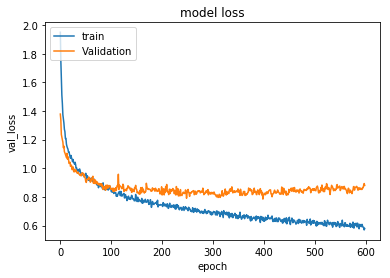

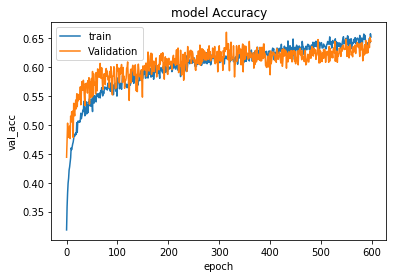

Loading Best Model
0.7730636827984845


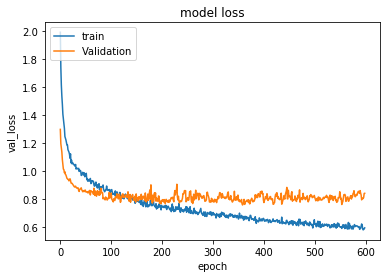

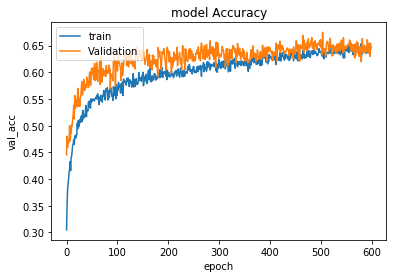

Loading Best Model
0.7385414144584602


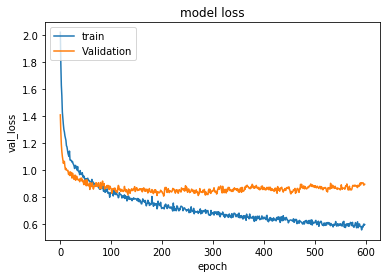

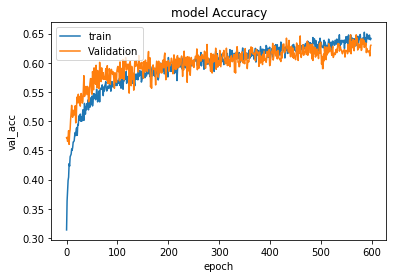

Loading Best Model
0.7959005595884651


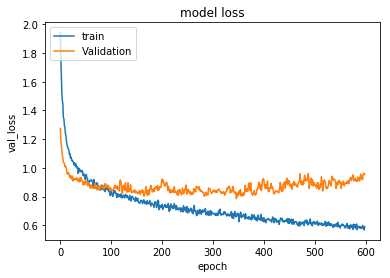

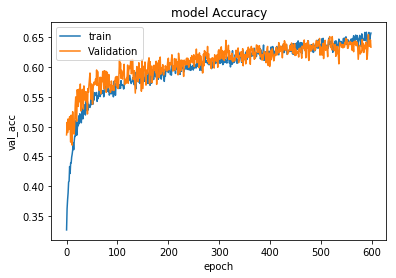

Loading Best Model
0.7811492750807045


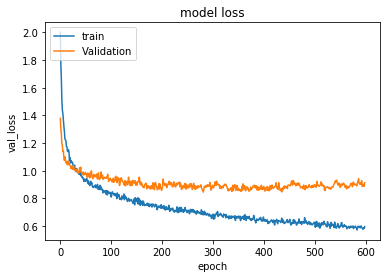

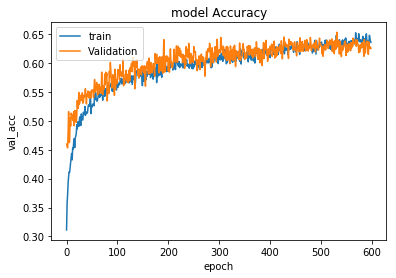

Loading Best Model
0.826676424550052
MULTI WEIGHTED LOG LOSS : 0.78289 


In [45]:
clfs = []
oof_preds = np.zeros((len(full_train_ss), len(classes)))
epochs = 600
batch_size = 100
for fold_, (trn_, val_) in enumerate(folds.split(y_map, y_map)):
    checkPoint = ModelCheckpoint("./keras.model",monitor='val_loss',mode = 'min', save_best_only=True, verbose=0)
    x_train, y_train = full_train_ss[trn_], y_categorical[trn_]
    x_valid, y_valid = full_train_ss[val_], y_categorical[val_]
    
    model = build_model(dropout_rate=0.5,activation='tanh')    
    model.compile(loss=mywloss, optimizer='adam', metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,shuffle=True,verbose=0,callbacks=[checkPoint])       
    
    plot_loss_acc(history)
    
    print('Loading Best Model')
    model.load_weights('./keras.model')
    # # Get predicted probabilities for each class
    oof_preds[val_, :] = model.predict_proba(x_valid,batch_size=batch_size)
    print(multi_weighted_logloss(y_valid, model.predict_proba(x_valid,batch_size=batch_size)))
    clfs.append(model)
    
print('MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_categorical,oof_preds))

In [46]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [47]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_map, np.argmax(oof_preds,axis=-1))
np.set_printoptions(precision=2)

In [48]:
sample_sub = pd.read_csv('./input/sample_submission.csv')
class_names = list(sample_sub.columns[1:-1])
del sample_sub;gc.collect()

5425

Normalized confusion matrix
[[9.01e-01 0.00e+00 3.97e-02 0.00e+00 0.00e+00 1.99e-02 0.00e+00 1.99e-02
  1.32e-02 6.62e-03 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [6.06e-03 7.17e-01 0.00e+00 3.84e-02 6.06e-02 0.00e+00 2.83e-02 1.21e-02
  4.04e-03 5.05e-02 2.02e-03 5.05e-02 0.00e+00 3.03e-02]
 [4.33e-03 0.00e+00 9.72e-01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  8.66e-03 0.00e+00 0.00e+00 0.00e+00 1.52e-02 0.00e+00]
 [4.19e-03 1.24e-01 0.00e+00 2.59e-01 1.67e-01 0.00e+00 1.38e-01 2.85e-02
  4.19e-03 9.97e-02 2.51e-03 1.42e-01 0.00e+00 3.10e-02]
 [0.00e+00 6.01e-02 0.00e+00 7.10e-02 3.55e-01 0.00e+00 9.29e-02 0.00e+00
  0.00e+00 1.80e-01 0.00e+00 2.35e-01 0.00e+00 5.46e-03]
 [3.33e-02 0.00e+00 0.00e+00 0.00e+00 0.00e+00 9.67e-01 0.00e+00 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [8.26e-03 4.34e-02 0.00e+00 9.09e-02 1.40e-01 0.00e+00 3.16e-01 6.82e-02
  2.07e-03 2.38e-01 0.00e+00 8.06e-02 0.00e+00 1.24e-02]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00

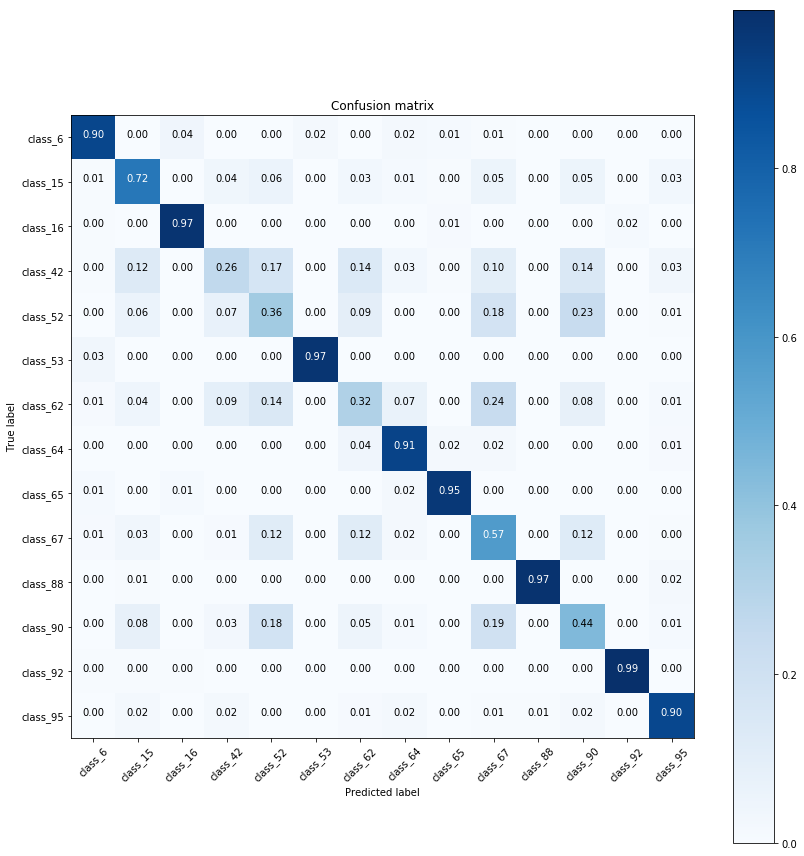

In [49]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(12,12))
foo = plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=True,
                      title='Confusion matrix')

In [ ]:
meta_test = pd.read_csv('./input/test_set_metadata.csv')
meta_dict = {}
meta_dict.update(haversine_plus(meta_test['ra'], meta_test['decl'], meta_test['gal_l'], meta_test['gal_b']))
meta_dict['hostgal_photoz_certain'] = meta_test['hostgal_photoz'] * np.exp(meta_test['hostgal_photoz_err'])

meta_test = pd.concat([meta_test, pd.DataFrame(meta_dict, index=meta_test.index)], axis=1)

start = time.time()
chunks = 5000000
for i_c, df in enumerate(pd.read_csv('./input/test_set.csv', chunksize=chunks, iterator=True)):
    df['flux_ratio_sq'] = np.power(df['flux'] / df['flux_err'], 2.0)
    df['flux_by_flux_ratio_sq'] = df['flux'] * df['flux_ratio_sq']
    # Group by object id
    agg_test = df.groupby('object_id').agg(aggs)
    agg_test.columns = new_columns
    agg_test['mjd_diff'] = agg_test['mjd_max'] - agg_test['mjd_min']
    agg_test['flux_diff'] = agg_test['flux_max'] - agg_test['flux_min']
    agg_test['flux_dif2'] = (agg_test['flux_max'] - agg_test['flux_min']) / agg_test['flux_mean']
    agg_test['flux_w_mean'] = agg_test['flux_by_flux_ratio_sq_sum'] / agg_test['flux_ratio_sq_sum']
    agg_test['flux_dif3'] = (agg_test['flux_max'] - agg_test['flux_min']) / agg_test['flux_w_mean']

    del agg_test['mjd_max'], agg_test['mjd_min']
    

    agg_df_ts_flux_passband = extract_features(df, 
                                               column_id='object_id', 
                                               column_sort='mjd', 
                                               column_kind='passband', 
                                               column_value='flux', 
                                               default_fc_parameters=fcp['flux_passband'], n_jobs=n_jobs)

    agg_df_ts_flux = extract_features(df, 
                                      column_id='object_id', 
                                      column_value='flux', 
                                      default_fc_parameters=fcp['flux'], n_jobs=n_jobs)

    agg_df_ts_flux_by_flux_ratio_sq = extract_features(df, 
                                      column_id='object_id', 
                                      column_value='flux_by_flux_ratio_sq', 
                                      default_fc_parameters=fcp['flux_by_flux_ratio_sq'], n_jobs=n_jobs)

    # Add smart feature that is suggested here https://www.kaggle.com/c/PLAsTiCC-2018/discussion/69696#410538
    # dt[detected==1, mjd_diff:=max(mjd)-min(mjd), by=object_id]
    df_det = df[df['detected']==1].copy()
    agg_df_mjd = extract_features(df_det, 
                                  column_id='object_id', 
                                  column_value='mjd', 
                                  default_fc_parameters=fcp['mjd'], n_jobs=n_jobs)
    
    agg_df_mjd['mjd_diff_det'] = agg_df_mjd['mjd__maximum'].values - agg_df_mjd['mjd__minimum'].values
    
    del agg_df_mjd['mjd__maximum'], agg_df_mjd['mjd__minimum']
    
    agg_df_ts_flux_passband.index.rename('object_id', inplace=True) 
    agg_df_ts_flux.index.rename('object_id', inplace=True) 
    agg_df_ts_flux_by_flux_ratio_sq.index.rename('object_id', inplace=True) 
    agg_df_mjd.index.rename('object_id', inplace=True)      
    agg_df_ts = pd.concat([agg_test, 
                           agg_df_ts_flux_passband, 
                           agg_df_ts_flux, 
                           agg_df_ts_flux_by_flux_ratio_sq, 
                           agg_df_mjd], axis=1).reset_index()

#     del df
#     gc.collect()
    
    # Merge with meta data
    full_test = agg_df_ts.merge(
        right=meta_test,
        how='left',
        on='object_id'
    )
    
    #if 'object_id' in full_train:
    #oof_df = full_train[['object_id']]
    del full_test['distmod'], full_test['hostgal_specz']
    del full_test['ra'], full_test['decl'], full_test['gal_l'],full_test['gal_b'],full_test['ddf']
    
    
    full_test[full_train.columns] = full_test[full_train.columns].fillna(train_mean)
    full_test_ss = ss.transform(full_test[full_train.columns])
    # Make predictions
    preds = None
    for clf in clfs:
        if preds is None:
            preds = clf.predict_proba(full_test_ss) / folds.n_splits
        else:
            preds += clf.predict_proba(full_test_ss) / folds.n_splits
    
   # Compute preds_99 as the proba of class not being any of the others
    # preds_99 = 0.1 gives 1.769
    preds_99 = np.ones(preds.shape[0])
    for i in range(preds.shape[1]):
        preds_99 *= (1 - preds[:, i])
    
    # Store predictions
    preds_df = pd.DataFrame(preds, columns=class_names)
    preds_df['object_id'] = full_test['object_id']
    preds_df['class_99'] = 0.14 * preds_99 / np.mean(preds_99) 
    
    if i_c == 0:
        preds_df.to_csv('predictions.csv',  header=True, mode='a', index=False)
    else: 
        preds_df.to_csv('predictions.csv',  header=False, mode='a', index=False)
        
    del agg_test, full_test, preds_df, preds
#     print('done')
    if (i_c + 1) % 10 == 0:
        print('%15d done in %5.1f' % (chunks * (i_c + 1), (time.time() - start) / 60))

Feature Extraction: 100%|██████████| 40/40 [00:04<00:00,  9.81it/s]


       50000000 done in  22.8


Feature Extraction: 100%|██████████| 40/40 [00:04<00:00, 11.68it/s]


      100000000 done in  48.5


Feature Extraction: 100%|██████████| 40/40 [00:04<00:00,  9.33it/s]


      150000000 done in  74.8


Feature Extraction: 100%|██████████| 40/40 [00:04<00:00,  9.39it/s]


      200000000 done in 101.0


Feature Extraction: 100%|██████████| 40/40 [00:04<00:00, 10.50it/s]


      250000000 done in 127.0


Feature Extraction: 100%|██████████| 40/40 [00:04<00:00,  9.53it/s]


      300000000 done in 153.1


Feature Extraction: 100%|██████████| 40/40 [00:04<00:00,  8.39it/s]


      350000000 done in 179.3


Feature Extraction: 100%|██████████| 40/40 [00:04<00:00, 11.08it/s]


In [ ]:
z = pd.read_csv('predictions.csv')

print(z.groupby('object_id').size().max())
print((z.groupby('object_id').size() > 1).sum())

z = z.groupby('object_id').mean()

z.to_csv('single_predictions2.csv', index=True)

In [45]:
z.head()

,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
object_id,,,,,,,,,,,,,,,
13,0.000138,0.010448,2.481207e-04,0.324106,0.289259,9.010549e-07,0.242498,0.000050,0.000247,0.020929,0.001802,0.109614,0.000007,0.000651,0.152704
14,0.000004,0.015355,2.048798e-05,0.103656,0.211477,4.296831e-05,0.056410,0.001401,0.000077,0.092404,0.011059,0.493165,0.000029,0.014898,0.143380
17,0.000019,0.019320,1.942520e-04,0.104689,0.137656,6.215925e-05,0.042417,0.001066,0.000095,0.047981,0.164770,0.402360,0.000435,0.078935,0.154575
23,0.000002,0.011539,2.921371e-06,0.113091,0.239810,1.251132e-05,0.067310,0.000527,0.000019,0.094522,0.002298,0.464594,0.000003,0.006271,0.145712
34,0.000026,0.011198,2.943411e-07,0.089239,0.173557,9.032043e-06,0.083001,0.000302,0.000060,0.120504,0.000236,0.464899,0.000002,0.056966,0.147716


In [10]:
train_df.head()

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [11]:
test_df.head()

,object_id,mjd,passband,flux,flux_err,detected
0,13,59798.3205,2,-1.299735,1.357315,0
1,13,59798.3281,1,-2.095392,1.148654,0
2,13,59798.3357,3,-0.923794,1.763655,0
3,13,59798.3466,4,-4.009815,2.602911,0
4,13,59798.3576,5,-3.403503,5.367328,0


In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1421705 entries, 0 to 1421704
Data columns (total 6 columns):
object_id    1421705 non-null int64
mjd          1421705 non-null float64
passband     1421705 non-null int64
flux         1421705 non-null float64
flux_err     1421705 non-null float64
detected     1421705 non-null int64
dtypes: float64(3), int64(3)
memory usage: 65.1 MB


In [13]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453653104 entries, 0 to 453653103
Data columns (total 6 columns):
object_id    int64
mjd          float64
passband     int64
flux         float64
flux_err     float64
detected     int64
dtypes: float64(3), int64(3)
memory usage: 20.3 GB


In [22]:
train_meta.groupby(['ddf']).size()

ddf
0    5732
1    2116
dtype: int64

In [21]:
test_meta.groupby(['ddf']).size()

ddf
0    3459964
1      32926
dtype: int64

In [24]:
train_df = downcast_dtypes(train_df)
test_df = downcast_dtypes(test_df)
train_meta = downcast_dtypes(train_meta)
test_meta = downcast_dtypes(test_meta)

In [28]:
train_meta[train_meta['distmod'].isnull()]

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796539,-51.753708,1,0.0,0.0,0.0,NaN,0.017,92
5,1227,35.683594,-5.379379,171.992950,-59.253502,1,0.0,0.0,0.0,NaN,0.020,65
9,1926,149.414062,1.940072,236.565369,41.393322,1,0.0,0.0,0.0,NaN,0.018,65
14,2624,346.655182,-63.260487,320.952209,-50.040936,1,0.0,0.0,0.0,NaN,0.019,65
15,2677,53.964844,-28.630989,225.142944,-53.813614,1,0.0,0.0,0.0,NaN,0.009,16
24,4171,2.097458,-45.783966,324.737854,-69.478615,1,0.0,0.0,0.0,NaN,0.011,16
32,6266,0.929752,-44.597992,328.531433,-70.083244,1,0.0,0.0,0.0,NaN,0.011,65
39,7566,359.446716,-44.201530,331.730011,-69.805710,1,0.0,0.0,0.0,NaN,0.010,16
42,7756,149.414062,2.238686,236.239761,41.565559,1,0.0,0.0,0.0,NaN,0.017,16
44,8688,32.695312,-4.929937,166.868469,-60.841228,1,0.0,0.0,0.0,NaN,0.018,65


In [30]:
train_meta.groupby(['target']).size()

target
6      151
15     495
16     924
42    1193
52     183
53      30
62     484
64     102
65     981
67     208
88     370
90    2313
92     239
95     175
dtype: int64

In [31]:
train_meta[train_meta['hostgal_specz']==0.0].count()

object_id             2325
ra                    2325
decl                  2325
gal_l                 2325
gal_b                 2325
ddf                   2325
hostgal_specz         2325
hostgal_photoz        2325
hostgal_photoz_err    2325
distmod                  0
mwebv                 2325
target                2325
dtype: int64

In [33]:
test_meta[test_meta['hostgal_photoz']==0.0].count()

object_id             390510
ra                    390510
decl                  390510
gal_l                 390510
gal_b                 390510
ddf                   390510
hostgal_specz              0
hostgal_photoz        390510
hostgal_photoz_err    390510
distmod                    0
mwebv                 390510
dtype: int64

In [37]:
train_meta['distmod'].isnull()

0        True
1       False
2       False
3       False
4       False
5        True
6       False
7       False
8       False
9        True
10      False
11      False
12      False
13      False
14       True
15       True
16      False
17      False
18      False
19      False
20      False
21      False
22      False
23      False
24       True
25      False
26      False
27      False
28      False
29      False
30      False
31      False
32       True
33      False
34      False
35      False
36      False
37      False
38      False
39       True
40      False
41      False
42       True
43      False
44       True
45      False
46       True
47       True
48       True
49      False
50      False
51       True
52      False
53       True
54      False
55      False
56       True
57      False
58      False
59      False
60       True
61      False
62       True
63      False
64      False
65      False
66      False
67       True
68      False
69       True
70       True
71    

In [38]:
enumerate(np.unique(train_meta['target']))

In [39]:
np.unique(train_meta['target'])

array([ 6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95],
      dtype=int32)